### Evaluation of Manipulation experiments

In [1]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt

%matplotlib notebook
from IPython.display import display

In [2]:
import os
import numpy as np
import signal_logger
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True
import rospkg

from utilities import *

rospack = rospkg.RosPack()
ROOT_DIR = os.path.join(rospack.get_path("mppi_manipulation_royalpanda"),
                        "logs")
LOG_PREFIX = "shelf"
LOG_FILE = os.path.join(ROOT_DIR, "filter.silo")
LOG_FILES = get_files(ROOT_DIR, LOG_PREFIX)
REQUIRED_FIELDS = [
    "log/sim_time", "log/stage_cost", "log/torque_command",
    "log/cartesian_limits_violation", "log/joint_limits_violation",
    "log/solver/rollouts/min_cost", "log/velocity_command",
    "log/velocity_filtered", "log/velocity_measured", "log/position_desired", "log/position_measured",
    "log/tank_state", "log/solver/delay_steps", "log/power_from_error", 
    "log/power_from_interaction", "log/total_power_exchange", "log/external_torque", "log/power_channels",
    "log/ground_truth_external_torque", "log/external_wrench", "log/external_wrench_filtered"
]
LOG_FILES_PRINT = '\n'.join(LOG_FILES)
print(f"""
>> Root dir: 
{ROOT_DIR}
>> Prefix: 
{LOG_PREFIX}
>> Log files: 
{LOG_FILES_PRINT}
""")


>> Root dir: 
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs
>> Prefix: 
shelf
>> Log files: 
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_3.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_filter_3.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_filter_6.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_1.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_filter_5.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_filter_4.silo
/home/giuseppe/catkin_ws/src/sampling_based_control/mppi_examples/mppi_manipulation_royalpanda/logs/shelf_filter_0.silo
/home/giuseppe/catkin_ws/s

### Fields available in log fie

In [3]:
silo = signal_logger.Silo(LOG_FILES[0])
#print_keys(silo)

Removing prefix /log/ which is common to all signals


### Some utilities
Use the naming convention to determine if the experiment was run with or without the filter and which object we try to manipulate

In [4]:
def has_filter_from_name(name):
    return "filter" in name

def get_object_from_name(name):
    object_types = ['shelf', 'door', 'microwave', 'drawer', 'valve']
    for object_type in object_types:
        if object_type in name:
            return object_type
    return 'none'

### Collect and process
Each experiment contributes to a single dictionary where all the information is stored

In [5]:
final_time = 35.0
data = {}
data['experiment_name'] = []
data['joint_limits_violation_se'] = []
data['cartesian_limits_violation_se'] = []
data['average_wrench_norm'] = []
data['safety_filter'] = []
data['object_type'] = []

for experiment_idx, file in enumerate(LOG_FILES):
    experiment_name = file.split('/')[-1].replace('.silo', '')
    silo = signal_logger.Silo(file)
    silo_dict = to_dictionary(silo, REQUIRED_FIELDS)

    for key, value in silo_dict.items():
        if experiment_idx == 0:
            data[key] = [value]
        else:
            data[key].append(value)
    
    time = silo_dict['sim_time']
    joint_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['joint_limits_violation'])
    carts_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['cartesian_limits_violation'])
    average_wrench = average_col_norm(time, 0.0, final_time, silo_dict['external_wrench_filtered'])
    
    data['experiment_name'].append(experiment_name)
    data['joint_limits_violation_se'].append(joint_violation_se)
    data['cartesian_limits_violation_se'].append(carts_violation_se)
    data['average_wrench_norm'].append(average_wrench)
    data['safety_filter'].append(has_filter_from_name(experiment_name))
    data['object_type'].append(get_object_from_name(experiment_name))

Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals
Removing prefix /log/ which is common to all signals


### Select experiment to plot

In [6]:
exp_idx = 0
exp_name_wg = widgets.Dropdown(options=data['experiment_name'])
def exp_name_handler(exp_name):
    exp_idx = data['experiment_name'].index(exp_name)
exp_name_wg.observe(exp_name_handler, names='value')

### Delay steps
The solver keeps track of delay in optimizing the plan to adapt which portion of input is optimized in the future.

Plotting shelf_filter_3


<IPython.core.display.Javascript object>


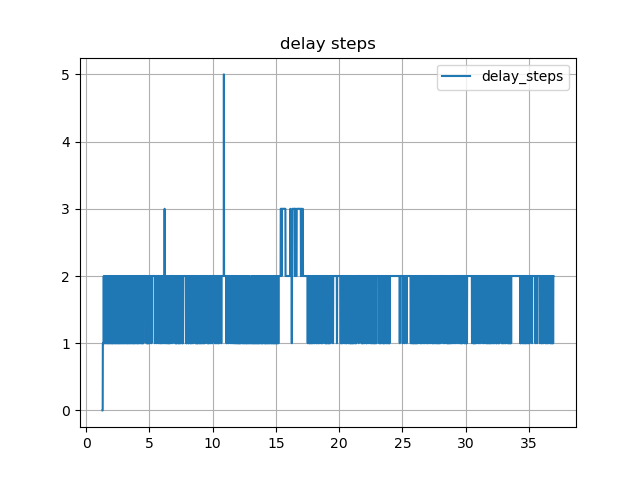

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'delay steps')

In [7]:
exp_idx = 1
print(f"Plotting {data['experiment_name'][exp_idx]}")
ax = scalar_plot(data['sim_time'][exp_idx], data['delay_steps'][exp_idx], prefix="delay_steps")
ax.set_title("delay steps")

### Wrench 

<IPython.core.display.Javascript object>


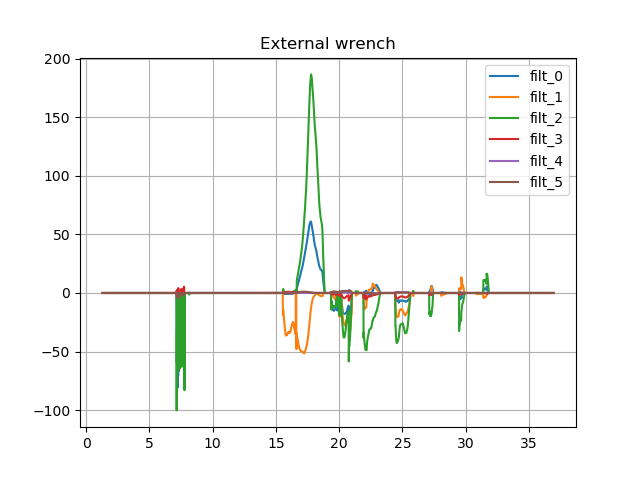

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'External wrench')

In [8]:
ax = matrix_plot(data['sim_time'][exp_idx], data['external_wrench_filtered'][exp_idx], prefix="filt")
#ax = matrix_plot(data['sim_time'][exp_idx], data['external_wrench'][exp_idx], prefix="raw",
#                axis=ax, linestyle="--")
ax.set_title("External wrench")

### Energy tank

<IPython.core.display.Javascript object>


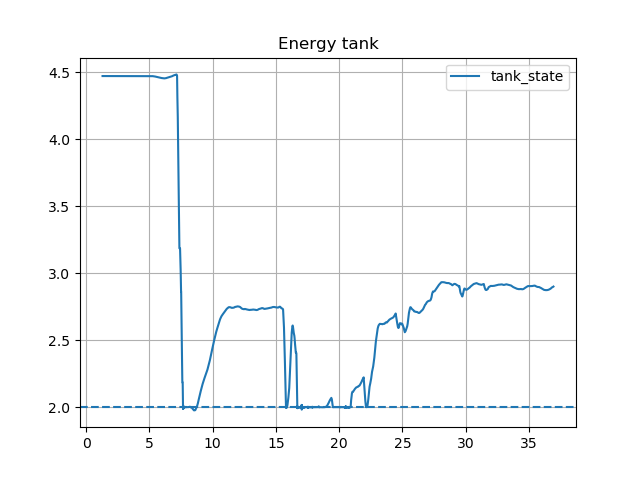

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


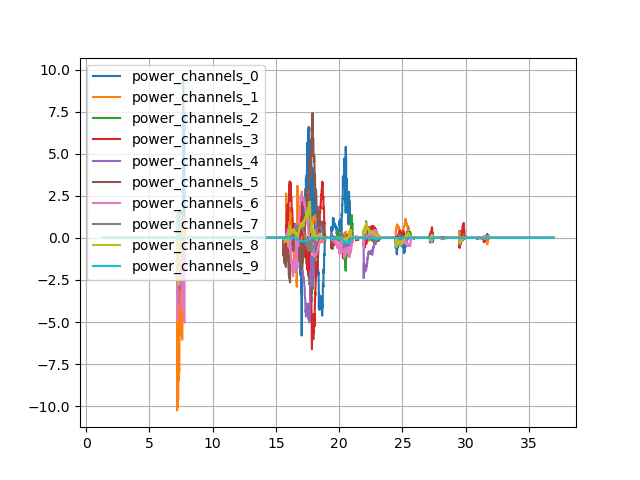

Button(description='Save Figure', style=ButtonStyle())

In [9]:
ax = scalar_plot(data['sim_time'][exp_idx], data['tank_state'][exp_idx], prefix="tank_state")
#ax.plot(data['sim_time'][exp_idx], data['power_from_error'][exp_idx], label="power_from_error")
#ax.plot(data['sim_time'][exp_idx], data['power_from_interaction'][exp_idx], label="power_from_interaction")
ax.axhline(y=2, ls="--")
ax.set_title("Energy tank")
ax.legend()

matrix_plot(data['sim_time'][exp_idx], data['power_channels'][exp_idx], prefix="power_channels")

### Torque measurements

<IPython.core.display.Javascript object>


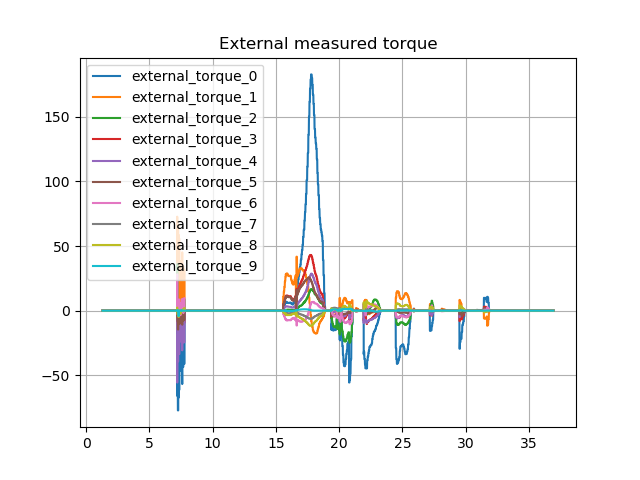

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


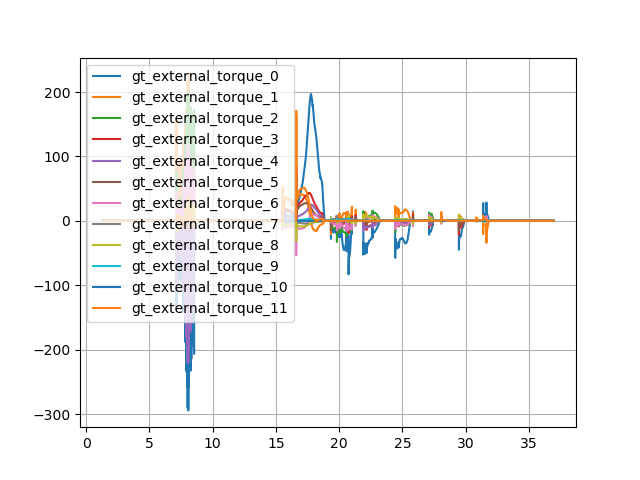

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


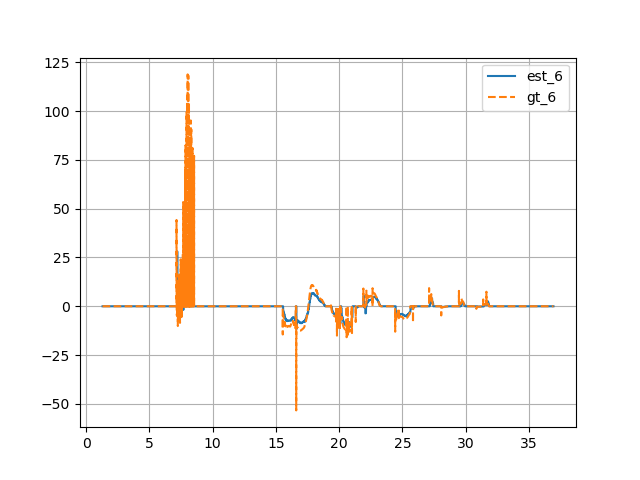

In [10]:
ax2 = matrix_plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx], prefix="external_torque")
ax2.set_title("External measured torque")
ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

ax = matrix_plot(data['sim_time'][exp_idx], data['ground_truth_external_torque'][exp_idx], 
                  prefix="gt_external_torque")
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

# Compare estimated against ground truth
uidx = 6
_, ax3 = plt.subplots()
ax3.plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx][:, uidx], label=f"est_{uidx}")
ax3.plot(data['sim_time'][exp_idx], data['ground_truth_external_torque'][exp_idx][:, uidx], '--', 
         label=f"gt_{uidx}")
ax3.legend()

### Stage cost

<IPython.core.display.Javascript object>


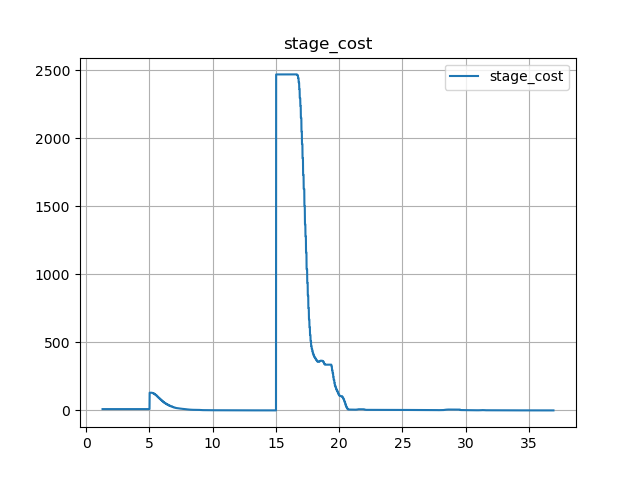

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'stage_cost')

In [11]:
ax = scalar_plot(data['sim_time'][exp_idx], data['stage_cost'][exp_idx], prefix="stage_cost")
ax.set_title("stage_cost")

### Min cost

<IPython.core.display.Javascript object>


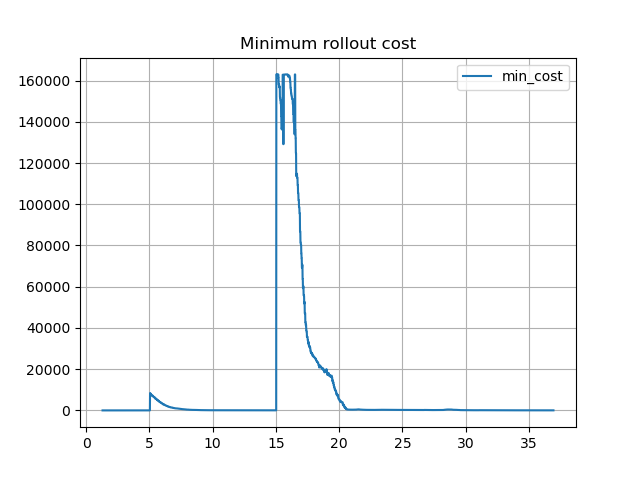

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Minimum rollout cost')

In [12]:
ax = scalar_plot(data['sim_time'][exp_idx], data['min_cost'][exp_idx], prefix="min_cost")
ax.set_title("Minimum rollout cost")

### Position desired

<IPython.core.display.Javascript object>


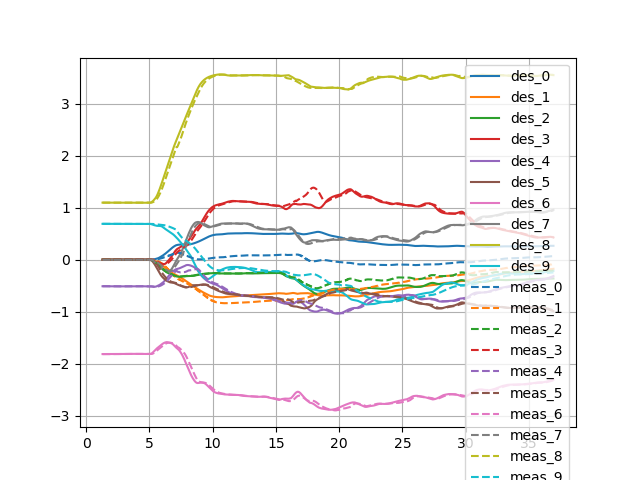

Button(description='Save Figure', style=ButtonStyle())

In [13]:
ax = matrix_plot(data['sim_time'][exp_idx], data['position_desired'][exp_idx], prefix="des")
ax = matrix_plot(data['sim_time'][exp_idx], data['position_measured'][exp_idx], prefix="meas", 
                 linestyle="--", axis=ax)

### Velocity measured

<IPython.core.display.Javascript object>


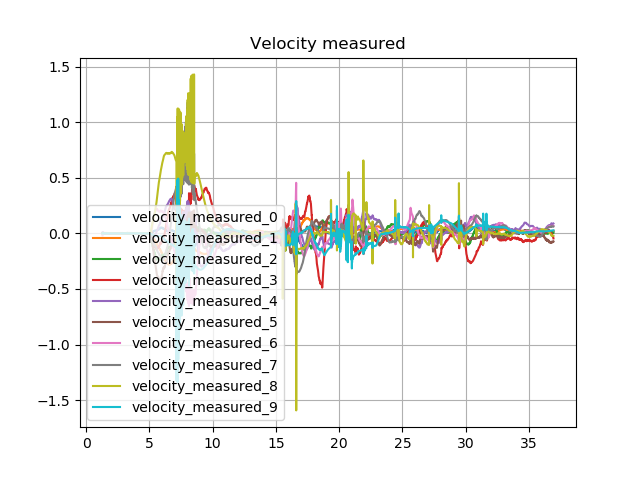

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Velocity measured')

In [14]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx], prefix="velocity_measured")
ax.set_title("Velocity measured")

### Velocity filtered

<IPython.core.display.Javascript object>


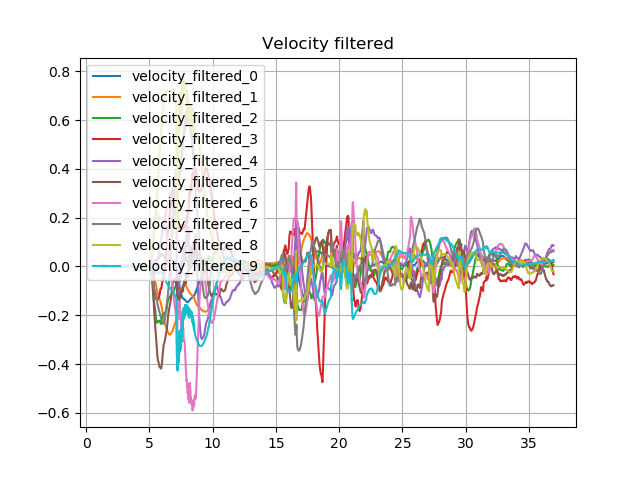

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


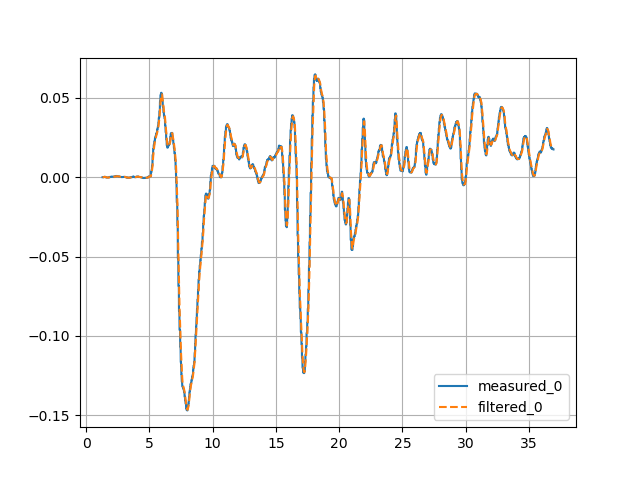

In [15]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx], prefix="velocity_filtered")
ax.set_title("Velocity filtered")

# Compare filtered agains measured
uidx = 0
fig2, ax2 = plt.subplots()
ax2.plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx][:, uidx], label=f"measured_{uidx}")
ax2.plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx][:, uidx], '--', label=f"filtered_{uidx}")
ax2.legend()


### Velocity command

<IPython.core.display.Javascript object>


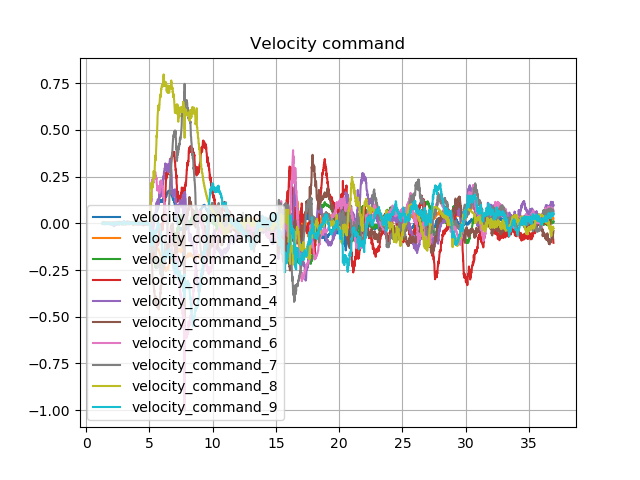

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Velocity command')

In [16]:
ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_command'][exp_idx], prefix="velocity_command")
ax.set_title("Velocity command")

### Torque command

<IPython.core.display.Javascript object>


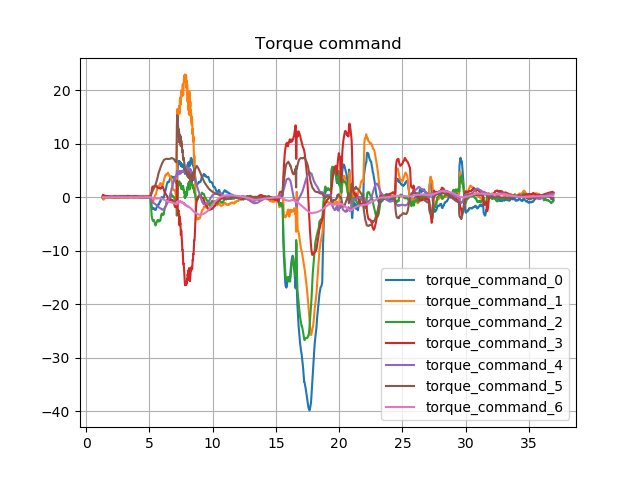

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Torque command')

In [17]:
ax = matrix_plot(data['sim_time'][exp_idx], data['torque_command'][exp_idx], prefix="torque_command")
ax.set_title("Torque command")

### Joint limits violation

<IPython.core.display.Javascript object>


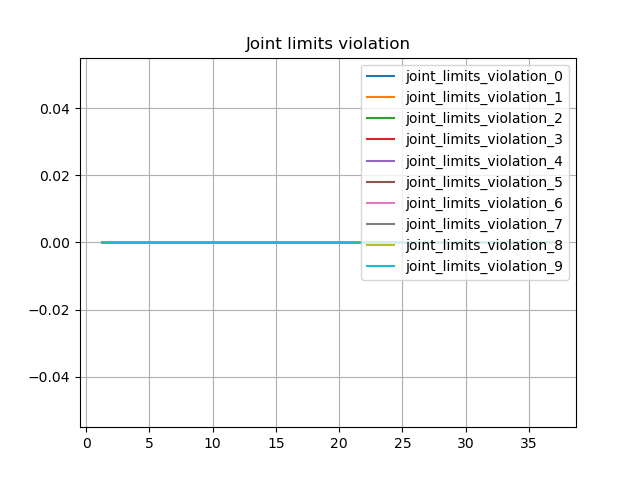

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Joint limits violation')

In [18]:
ax = matrix_plot(data['sim_time'][exp_idx], data['joint_limits_violation'][exp_idx], 
                 prefix="joint_limits_violation")
ax.set_title("Joint limits violation")

### Cartesian limits violation

<IPython.core.display.Javascript object>


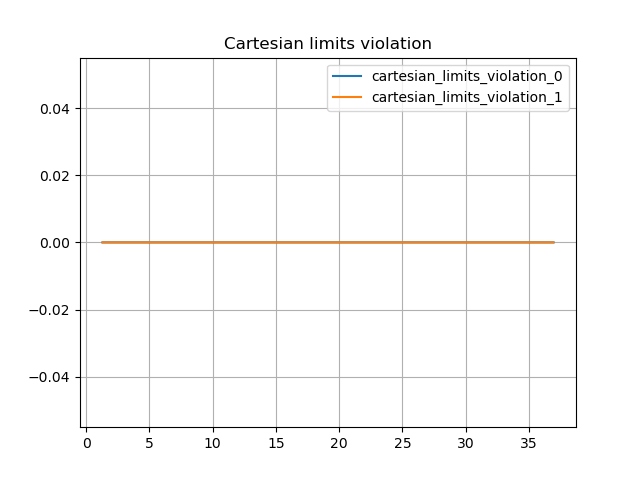

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Cartesian limits violation')

In [19]:
ax = matrix_plot(data['sim_time'][exp_idx], data['cartesian_limits_violation'][exp_idx], 
            prefix="cartesian_limits_violation")
ax.set_title("Cartesian limits violation")

### Squared violation

In [20]:
# Compare the following cases
comparison_labels = ["no_filter", "filter"]

<IPython.core.display.Javascript object>


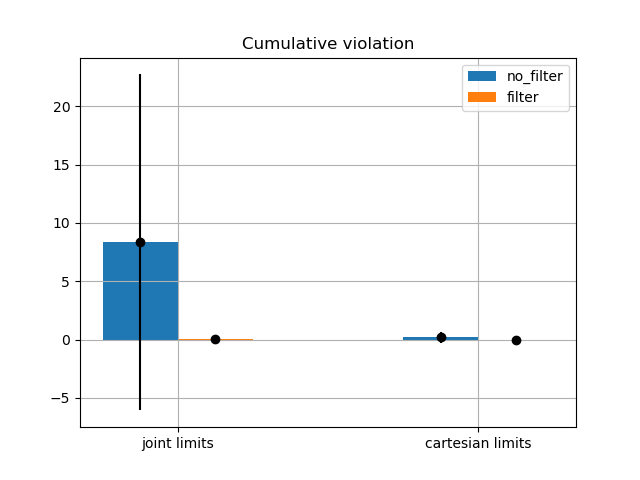

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Cumulative violation')

In [21]:
limits_index = ["joint limits", "cartesian limits"]

# cumulate all the values for filter/no_filter experiments
data_filter = [[], []]
data_no_filter = [[], []]
for i, has_filter in enumerate(data['safety_filter']):
    jlv = data['joint_limits_violation_se'][i]
    clv = data['cartesian_limits_violation_se'][i]
    if has_filter:
        data_filter[0].append(jlv)
        data_filter[1].append(clv)
    else:
        data_no_filter[0].append(jlv)
        data_no_filter[1].append(clv)
     
ax = bar_plot(limits_index, 
              comparison_labels, 
              data_no_filter, data_filter)
ax.set_title("Cumulative violation")

<IPython.core.display.Javascript object>


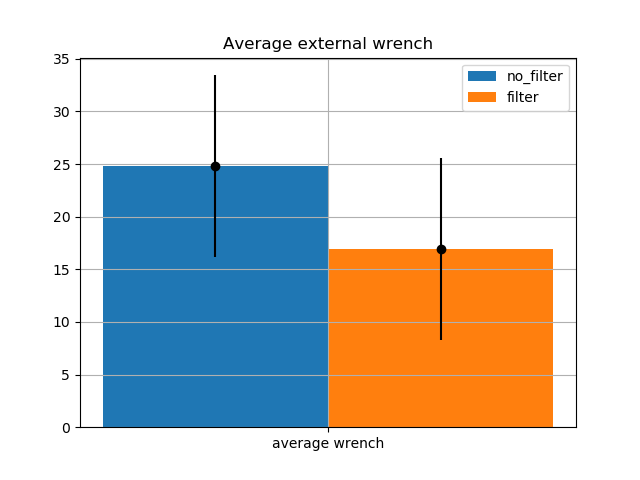

Button(description='Save Figure', style=ButtonStyle())

Text(0.5, 1.0, 'Average external wrench')

In [22]:
# cumulate all the values for filter/no_filter experiments
data_wrench_filter = [[]]
data_wrench_no_filter = [[]]
for i, has_filter in enumerate(data['safety_filter']):
    awn = data['average_wrench_norm'][i]
    if has_filter:
        data_wrench_filter[0].append(awn)
    else:
        data_wrench_no_filter[0].append(awn)
     
ax = bar_plot(["average wrench"], 
              comparison_labels, 
              data_wrench_no_filter, data_wrench_filter)
ax.set_title("Average external wrench")